In [1]:

import pandas as pd
import numpy as np
import psycopg2
from scipy.stats import linregress
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Warnings for seaborn

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')

In [3]:
# Set a Seaborn style and get the default color palette
sns.set(style="whitegrid")
sns.set_palette("bright")
colors = sns.color_palette()  

### DB Connection

In [4]:
# Parameters

host = "ec2-63-35-201-247.eu-west-1.compute.amazonaws.com"
port = "5432"
user = "postgres"
password = "Be6DkBT9FfY7CQ2vtj3Lpr6Wzqxax9"
database = "openremote"
batch_size = 500000



idMap = {
    "4gBLwNljLBlc0oYpBdpGkD" : "ht_wp_1_id",
    "475wGcmfSE0L1wguboGfpW": "ht_wp_2_id",
    "43wZIInlpD6YFsEc8TkwlN": "weather",
    "30cjCSTbgsokSNalNoBbJh": "energie_prijs"
}

def map_entity_id(entity_id):
    return idMap.get(entity_id, "no entity id found")

attribute_names = [
    "energyImportTotal", 
    "temperature",
    "energy",
    "currentPrice"
]

current_date = datetime.now().strftime("%Y%m%d")
file_name = "ht1_ht2_vs_energy_price"


# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    dbname=database
)

# Create a cursor object
cur = conn.cursor()

def fetch_batch(offset):
    query = f"""
    SELECT * FROM asset_datapoint 
    WHERE entity_id IN ({', '.join("'" + id + "'" for id in idMap.keys())})
    AND attribute_name IN ({', '.join("'" + name + "'" for name in attribute_names)})
    LIMIT {batch_size} OFFSET {offset};
    """
    cur.execute(query)
    rows = cur.fetchall()
    columns = [desc[0] for desc in cur.description]
    return pd.DataFrame(rows, columns=columns)

# Function to get the total number of rows
def get_total_rows():
    query = f"""
    SELECT COUNT(*) FROM asset_datapoint 
     WHERE entity_id IN ({', '.join("'" + id + "'" for id in idMap.keys())})
    AND attribute_name IN ({', '.join("'" + id + "'" for id in attribute_names)})
    """
    cur.execute(query)
    total_rows = cur.fetchone()[0]
    return total_rows

In [5]:
# Get the total number of rows
total_rows = get_total_rows()
print(f"Total rows to process: {total_rows}")

# Calculate the number of batches
num_batches = (total_rows + batch_size - 1) // batch_size

Total rows to process: 549160


In [6]:
# Placeholder for processed data
processed_batches = []


# Process each batch
for i in range(num_batches):
    offset = i * batch_size
    print(f"Processing batch {i + 1}: OFFSET {offset}")

    # Fetch the batch
    batch_df = fetch_batch(offset)
    
    # Add new column
    batch_df['attributename_id'] = batch_df['entity_id'].apply(map_entity_id) + '_' +  batch_df['attribute_name']  
#     print(batch_df.columns)
    
    # Convert timestamp to datetime
#     batch_df['timestamp'] = pd.to_datetime(batch_df['timestamp'], format='mixed')
    batch_df['timestamp'] = pd.to_datetime(batch_df['timestamp'], errors='coerce')
    
    if batch_df['timestamp'].isnull().all():
        print(f"All timestamps in batch {i + 1} are NaT")
        continue
    
    # Pivot the DataFrame
    batch_pivoted_df = batch_df.pivot(index='timestamp', columns='attributename_id', values='value')
#     print(batch_pivoted_df.head())
    
    
    if batch_pivoted_df is None or batch_pivoted_df.empty:
        print(f"Pivoted DataFrame for batch {i + 1} is empty or None")
        continue
    # Reset index
#     batch_pivoted_df2 = batch_pivoted_df.reset_index('timestamp')

#     print(batch_pivoted_df.head())
    
    # Convert specified columns to numeric
#     for kolom in numeric_data:
#         if kolom in batch_pivoted_df.columns:
#             batch_pivoted_df[kolom] = pd.to_numeric(batch_pivoted_df[kolom], errors='coerce')
            
    for kolom in batch_pivoted_df.columns:
         batch_pivoted_df[kolom] = pd.to_numeric(batch_pivoted_df[kolom], errors='coerce')
        
    # Reset index to include 'timestamp' in the columns
#     batch_pivoted_df2 = batch_pivoted_df.reset_index('timestamp', inplace=True)
    batch_pivoted_df2 = batch_pivoted_df.reset_index('timestamp')
    
#     print(batch_pivoted_df2.head())
    
    
    # Add the processed batch to the list
    processed_batches.append(batch_pivoted_df2)

# Concatenate all processed batches into one DataFrame
processed_data = pd.concat(processed_batches)

Processing batch 1: OFFSET 0
Processing batch 2: OFFSET 500000


In [7]:
processed_data.head()

attributename_id,timestamp,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature
0,2023-12-16 00:00:01.870,67.199997,NaN,NaN,NaN
1,2023-12-16 00:00:01.877,75.160000,NaN,NaN,NaN
2,2023-12-16 01:00:00.235,55.640000,NaN,NaN,NaN
3,2023-12-16 02:00:01.620,56.000000,NaN,NaN,NaN
4,2023-12-16 03:00:01.894,58.000000,NaN,NaN,NaN


In [8]:
print(processed_data)

attributename_id               timestamp  energie_prijs_currentPrice  \
0                2023-12-16 00:00:01.870                   67.199997   
1                2023-12-16 00:00:01.877                   75.160000   
2                2023-12-16 01:00:00.235                   55.640000   
3                2023-12-16 02:00:01.620                   56.000000   
4                2023-12-16 03:00:01.894                   58.000000   
...                                  ...                         ...   
48430            2025-01-28 03:57:07.463                         NaN   
48431            2025-01-28 03:57:07.468                         NaN   
48432            2025-01-28 03:59:05.290                         NaN   
48433            2025-01-28 03:59:07.728                         NaN   
48434            2025-01-28 03:59:07.734                         NaN   

attributename_id  ht_wp_1_id_energyImportTotal  ht_wp_2_id_energyImportTotal  \
0                                          NaN         

In [7]:
print(processed_data.columns)


# Check for duplicates and missing values
# processed_data = processed_data.drop_duplicates(subset='timestamp')
processed_data['timestamp'] = pd.to_datetime(processed_data['timestamp'], errors='coerce')
# processed_data['timestamp'] = pd.to_datetime(processed_data['timestamp'])

# Check for duplicates and missing values
# processed_data = processed_data.drop_duplicates(subset='timestamp')
# processed_data = processed_data.dropna(subset=['timestamp'])

# Ensure 'timestamp' column is still present
if 'timestamp' not in processed_data.columns:
    print("Error: 'timestamp' column is missing after processing")
else:
    print("'timestamp' column is present after processing")

# processed_data = processed_data.set_index('timestamp')


# Set the timestamp as index
# processed_data.set_index('timestamp', inplace=True)

# Ensure 'timestamp' is set as index
if processed_data.index.name != 'timestamp':
    print("Error: 'timestamp' is not set as index")
else:
    print("'timestamp' is set as index")

Index(['timestamp', 'energie_prijs_currentPrice',
       'ht_wp_1_id_energyImportTotal', 'ht_wp_2_id_energyImportTotal',
       'weather_temperature'],
      dtype='object', name='attributename_id')
'timestamp' column is present after processing
Error: 'timestamp' is not set as index


In [8]:
# processed_data = processed_data.set_index('timestamp')

print(processed_data.head(1))
print(processed_data.tail(1))

attributename_id               timestamp  energie_prijs_currentPrice  \
0                2023-12-16 00:00:01.870                   67.199997   

attributename_id  ht_wp_1_id_energyImportTotal  ht_wp_2_id_energyImportTotal  \
0                                          NaN                           NaN   

attributename_id  weather_temperature  
0                                 NaN  
attributename_id               timestamp  energie_prijs_currentPrice  \
377386           2024-10-17 04:59:46.213                         NaN   

attributename_id  ht_wp_1_id_energyImportTotal  ht_wp_2_id_energyImportTotal  \
377386                                     NaN                           NaN   

attributename_id  weather_temperature  
377386                          15.12  


In [9]:
# Close the cursor and connection
cur.close()
conn.close()

In [10]:
processed_data.describe()

attributename_id,timestamp,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature
count,377387,7710.000000,191678.000000,199696.000000,15665.000000
mean,2024-06-11 01:52:38.450541824,69.997916,181136.597325,303944.360533,17.613641
min,2023-12-16 00:00:01.870000,-200.000000,0.000000,0.000000,4.040000
25%,2024-04-18 17:59:03.808999936,53.330000,174148.000000,290166.000000,14.460000
50%,2024-06-06 13:12:06.638000128,74.980000,178232.000000,305566.000000,17.430000
75%,2024-07-25 11:51:02.487000064,92.557500,188058.000000,315658.250000,20.630000
max,2024-10-17 04:59:46.213000,303.000000,206037.000000,328162.000000,32.290000
std,NaN,39.958465,11555.307829,16920.556003,4.747028


In [11]:
processed_data.set_index('timestamp', inplace=True)
processed_data.head()

attributename_id,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature
timestamp,,,,
2023-12-16 00:00:01.870,67.199997,NaN,NaN,NaN
2023-12-16 00:00:01.877,75.160000,NaN,NaN,NaN
2023-12-16 01:00:00.235,55.640000,NaN,NaN,NaN
2023-12-16 02:00:01.620,56.000000,NaN,NaN,NaN
2023-12-16 03:00:01.894,58.000000,NaN,NaN,NaN


In [12]:
print(processed_data.columns)

Index(['energie_prijs_currentPrice', 'ht_wp_1_id_energyImportTotal',
       'ht_wp_2_id_energyImportTotal', 'weather_temperature'],
      dtype='object', name='attributename_id')


### CSV

In [13]:
processed_data.to_csv(current_date + file_name + ".csv")

In [14]:

savedDataF = pd.read_csv("C:/Users/Piotr S/Desktop/Python_projects_mine/DB test/20241010ht1_ht2_vs_energy_price.csv")

In [15]:
savedDataF.head()

,timestamp,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature
0,2023-12-16 00:00:01.870,67.199997,NaN,NaN,NaN
1,2023-12-16 00:00:01.877,75.160000,NaN,NaN,NaN
2,2023-12-16 01:00:00.235,55.640000,NaN,NaN,NaN
3,2023-12-16 02:00:01.620,56.000000,NaN,NaN,NaN
4,2023-12-16 03:00:01.894,58.000000,NaN,NaN,NaN


In [16]:
savedDataF['timestamp'] = pd.to_datetime(savedDataF['timestamp'], errors='coerce')
savedDataF.set_index('timestamp', inplace=True)

In [17]:
print(savedDataF.columns)
print(savedDataF.index)

Index(['energie_prijs_currentPrice', 'ht_wp_1_id_energyImportTotal',
       'ht_wp_2_id_energyImportTotal', 'weather_temperature'],
      dtype='object')
DatetimeIndex(['2023-12-16 00:00:01.870000', '2023-12-16 00:00:01.877000',
               '2023-12-16 01:00:00.235000', '2023-12-16 02:00:01.620000',
               '2023-12-16 03:00:01.894000', '2023-12-16 04:00:00.094000',
               '2023-12-16 05:00:01.433000', '2023-12-16 06:00:02.847000',
               '2023-12-16 07:00:00.980000', '2023-12-16 08:00:01.957000',
               ...
               '2024-10-10 04:48:33.713000', '2024-10-10 04:49:33.872000',
               '2024-10-10 04:51:34.117000', '2024-10-10 04:51:34.123000',
               '2024-10-10 04:53:34.336000', '2024-10-10 04:55:34.588000',
               '2024-10-10 04:57:34.782000', '2024-10-10 04:57:34.788000',
               '2024-10-10 04:58:33.773000', '2024-10-10 04:59:34.963000'],
              dtype='datetime64[ns]', name='timestamp', length=374028, freq=

In [18]:
first_non_zero_index = savedDataF[(savedDataF[['ht_wp_1_id_energyImportTotal', 'ht_wp_2_id_energyImportTotal']] != 0.0).any(axis=1)].index[0]
fullDataSet = savedDataF.loc[first_non_zero_index:]
fullDataSet.head()



,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature
timestamp,,,,
2023-12-16 00:00:01.870,67.199997,NaN,NaN,NaN
2023-12-16 00:00:01.877,75.160000,NaN,NaN,NaN
2023-12-16 01:00:00.235,55.640000,NaN,NaN,NaN
2023-12-16 02:00:01.620,56.000000,NaN,NaN,NaN
2023-12-16 03:00:01.894,58.000000,NaN,NaN,NaN


In [19]:
print(fullDataSet.isna().sum())

energie_prijs_currentPrice      366954
ht_wp_1_id_energyImportTotal    183861
ht_wp_2_id_energyImportTotal    175843
weather_temperature             358681
dtype: int64


In [20]:
print((fullDataSet))

                         energie_prijs_currentPrice  \
timestamp                                             
2023-12-16 00:00:01.870                   67.199997   
2023-12-16 00:00:01.877                   75.160000   
2023-12-16 01:00:00.235                   55.640000   
2023-12-16 02:00:01.620                   56.000000   
2023-12-16 03:00:01.894                   58.000000   
...                                             ...   
2024-10-10 04:55:34.588                         NaN   
2024-10-10 04:57:34.782                         NaN   
2024-10-10 04:57:34.788                         NaN   
2024-10-10 04:58:33.773                         NaN   
2024-10-10 04:59:34.963                         NaN   

                         ht_wp_1_id_energyImportTotal  \
timestamp                                               
2023-12-16 00:00:01.870                           NaN   
2023-12-16 00:00:01.877                           NaN   
2023-12-16 01:00:00.235                           NaN   

In [21]:
print(fullDataSet.index)

DatetimeIndex(['2023-12-16 00:00:01.870000', '2023-12-16 00:00:01.877000',
               '2023-12-16 01:00:00.235000', '2023-12-16 02:00:01.620000',
               '2023-12-16 03:00:01.894000', '2023-12-16 04:00:00.094000',
               '2023-12-16 05:00:01.433000', '2023-12-16 06:00:02.847000',
               '2023-12-16 07:00:00.980000', '2023-12-16 08:00:01.957000',
               ...
               '2024-10-10 04:48:33.713000', '2024-10-10 04:49:33.872000',
               '2024-10-10 04:51:34.117000', '2024-10-10 04:51:34.123000',
               '2024-10-10 04:53:34.336000', '2024-10-10 04:55:34.588000',
               '2024-10-10 04:57:34.782000', '2024-10-10 04:57:34.788000',
               '2024-10-10 04:58:33.773000', '2024-10-10 04:59:34.963000'],
              dtype='datetime64[ns]', name='timestamp', length=374028, freq=None)


In [22]:
print(fullDataSet.columns)
print(fullDataSet.columns[1])

Index(['energie_prijs_currentPrice', 'ht_wp_1_id_energyImportTotal',
       'ht_wp_2_id_energyImportTotal', 'weather_temperature'],
      dtype='object')
ht_wp_1_id_energyImportTotal


In [23]:
fullDataSet.describe()

,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature
count,7074.000000,190167.000000,198185.000000,15347.000000
mean,67.851520,180940.696693,303761.254262,17.724126
std,40.455778,11389.365453,16853.981382,4.689026
min,-200.000000,0.000000,0.000000,4.040000
25%,50.000000,174148.000000,290027.000000,14.540000
50%,73.410000,178027.000000,305406.000000,17.500000
75%,91.050000,187587.000000,315140.000000,20.710000
max,303.000000,203855.000000,327409.000000,32.290000


### Agregation

In [24]:
aggregration_functions = {}
for column in fullDataSet.columns:
    if "energy" in column:
        aggregration_functions[column] = "last"
    else:
        aggregration_functions[column] = "mean"

print(aggregration_functions)

{'energie_prijs_currentPrice': 'mean', 'ht_wp_1_id_energyImportTotal': 'last', 'ht_wp_2_id_energyImportTotal': 'last', 'weather_temperature': 'mean'}


In [25]:
df_res = fullDataSet.resample('1h').agg(aggregration_functions)
df_res =df_res.dropna()
print(df_res.isna().sum())
df_res.head()

energie_prijs_currentPrice      0
ht_wp_1_id_energyImportTotal    0
ht_wp_2_id_energyImportTotal    0
weather_temperature             0
dtype: int64


,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature
timestamp,,,,
2024-06-17 15:00:00,46.15,181358.0,308168.0,20.655556
2024-06-17 16:00:00,54.07,181382.0,308177.0,20.998333
2024-06-17 17:00:00,77.54,181401.0,308177.0,20.933333
2024-06-17 18:00:00,101.36,181420.0,308177.0,20.860000
2024-06-17 19:00:00,139.00,181439.0,308177.0,20.355000


In [26]:
print(df_res)

                     energie_prijs_currentPrice  ht_wp_1_id_energyImportTotal  \
timestamp                                                                       
2024-06-17 15:00:00                       46.15                      181358.0   
2024-06-17 16:00:00                       54.07                      181382.0   
2024-06-17 17:00:00                       77.54                      181401.0   
2024-06-17 18:00:00                      101.36                      181420.0   
2024-06-17 19:00:00                      139.00                      181439.0   
...                                         ...                           ...   
2024-10-10 00:00:00                       75.10                      203801.0   
2024-10-10 01:00:00                       72.52                      203822.0   
2024-10-10 02:00:00                       76.60                      203822.0   
2024-10-10 03:00:00                       79.90                      203823.0   
2024-10-10 04:00:00         

In [27]:
df_res.describe()

,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature
count,2562.000000,2562.000000,2562.000000,2562.000000
mean,74.635423,191769.378610,318537.575722,17.727927
std,46.298154,6368.842711,5425.933269,4.682636
min,-149.000000,181358.000000,308168.000000,4.253333
25%,50.000000,186635.500000,313834.250000,14.550417
50%,83.300000,191052.000000,318607.000000,17.521667
75%,100.927500,196807.500000,323889.500000,20.716250
max,303.000000,203855.000000,327409.000000,31.833333


In [28]:
fullDataSet.describe()

,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature
count,7074.000000,190167.000000,198185.000000,15347.000000
mean,67.851520,180940.696693,303761.254262,17.724126
std,40.455778,11389.365453,16853.981382,4.689026
min,-200.000000,0.000000,0.000000,4.040000
25%,50.000000,174148.000000,290027.000000,14.540000
50%,73.410000,178027.000000,305406.000000,17.500000
75%,91.050000,187587.000000,315140.000000,20.710000
max,303.000000,203855.000000,327409.000000,32.290000


In [29]:
#Similar, agregation went well

### Deltas

In [30]:
delta_columns = ["energie_prijs_currentPrice","ht_wp_1_id_energyImportTotal", "ht_wp_2_id_energyImportTotal", "weather_temperature"]
df_res = df_res.copy()

for col in delta_columns:
     df_res.loc[:, f'{col}_delta'] = df_res[col].diff()

In [31]:
df_res = df_res.dropna()
df_res.head()
df_res = df_res.iloc[1:, :]
  

In [32]:
print(df_res.isna().sum())

energie_prijs_currentPrice            0
ht_wp_1_id_energyImportTotal          0
ht_wp_2_id_energyImportTotal          0
weather_temperature                   0
energie_prijs_currentPrice_delta      0
ht_wp_1_id_energyImportTotal_delta    0
ht_wp_2_id_energyImportTotal_delta    0
weather_temperature_delta             0
dtype: int64


In [33]:
df_res = df_res.dropna()

In [34]:
df_res.describe()

,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature,energie_prijs_currentPrice_delta,ht_wp_1_id_energyImportTotal_delta,ht_wp_2_id_energyImportTotal_delta,weather_temperature_delta
count,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000
mean,74.654584,191777.503125,318545.673438,17.725506,0.007133,8.778516,7.512500,-0.003165
std,46.311031,6364.689308,5420.307147,4.683661,23.016751,20.086871,20.113527,0.882006
min,-149.000000,181401.000000,308177.000000,4.253333,-121.050000,0.000000,0.000000,-5.565000
25%,50.000000,186649.000000,313838.000000,14.545833,-11.265000,0.000000,0.000000,-0.505000
50%,83.365000,191062.000000,318611.000000,17.520000,-1.285000,3.000000,1.000000,-0.135833
75%,100.955000,196810.000000,323890.000000,20.715417,10.545000,14.000000,10.000000,0.454167
max,303.000000,203855.000000,327409.000000,31.833333,149.570000,846.000000,615.000000,5.967500


In [35]:
df_res.head(50)

,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature,energie_prijs_currentPrice_delta,ht_wp_1_id_energyImportTotal_delta,ht_wp_2_id_energyImportTotal_delta,weather_temperature_delta
timestamp,,,,,,,,
2024-06-17 17:00:00,77.54,181401.0,308177.0,20.933333,23.47,19.0,0.0,-0.065000
2024-06-17 18:00:00,101.36,181420.0,308177.0,20.860000,23.82,19.0,0.0,-0.073333
2024-06-17 19:00:00,139.00,181439.0,308177.0,20.355000,37.64,19.0,0.0,-0.505000
2024-06-17 20:00:00,181.54,181446.0,308197.0,19.313333,42.54,7.0,20.0,-1.041667
2024-06-17 21:00:00,196.93,181446.0,308217.0,17.941667,15.39,0.0,20.0,-1.371667
2024-06-17 22:00:00,126.61,181446.0,308237.0,16.290000,-70.32,0.0,20.0,-1.651667
2024-06-17 23:00:00,103.39,181446.0,308261.0,14.955000,-23.22,0.0,24.0,-1.335000
2024-06-18 00:00:00,70.16,181446.0,308266.0,14.320000,-33.23,0.0,5.0,-0.635000
2024-06-18 01:00:00,84.90,181446.0,308266.0,13.901667,14.74,0.0,0.0,-0.418333


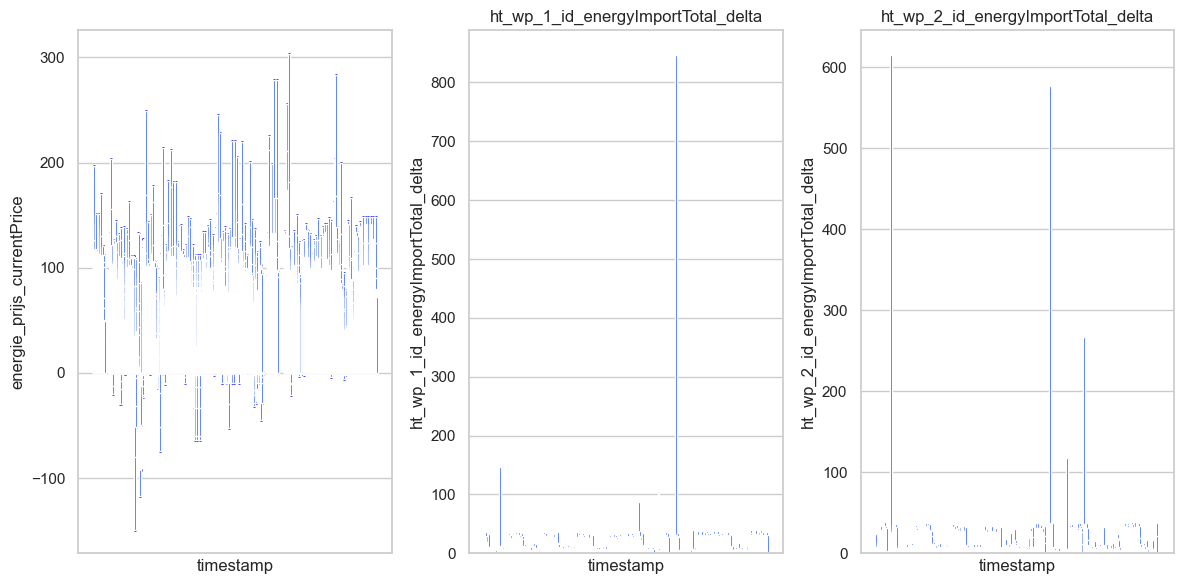

In [36]:
# Raw diagrams to take a look at the data

plt.figure(figsize=(12, 6))

col="energie_prijs_currentPrice"
x = df_res.index  
y = df_res[str(col)]
plt.subplot(1, 3, 1) 
plt.scatter(x, y, s=1, color='blue') 
plt.bar(x, y)
plt.xlabel(df_res.index.name)  
plt.xticks([])
plt.ylabel(col)  
plt.grid(True)  

col="ht_wp_1_id_energyImportTotal_delta"
x = df_res.index  
y = df_res[str(col)]
plt.subplot(1, 3, 2) 
plt.bar(x, y) 
plt.title(col)  
plt.xlabel(df_res.index.name)  
plt.xticks([])
plt.ylabel(col)  
plt.grid(True)  

col="ht_wp_2_id_energyImportTotal_delta"
x = df_res.index  
y = df_res[str(col)]
plt.subplot(1, 3, 3) 
plt.bar(x, y)
plt.title(col)  
plt.xlabel(df_res.index.name)  
plt.xticks([])
plt.ylabel(col)  
plt.grid(True)  
    
plt.tight_layout()  
plt.show()


timestamp
2024-06-17 17:00:00    181401.0
2024-06-17 18:00:00    181420.0
2024-06-17 19:00:00    181439.0
2024-06-17 20:00:00    181446.0
2024-06-17 21:00:00    181446.0
                         ...   
2024-10-10 00:00:00    203801.0
2024-10-10 01:00:00    203822.0
2024-10-10 02:00:00    203822.0
2024-10-10 03:00:00    203823.0
2024-10-10 04:00:00    203855.0
Name: ht_wp_1_id_energyImportTotal, Length: 2560, dtype: float64 timestamp
2024-06-17 17:00:00     77.54
2024-06-17 18:00:00    101.36
2024-06-17 19:00:00    139.00
2024-06-17 20:00:00    181.54
2024-06-17 21:00:00    196.93
                        ...  
2024-10-10 00:00:00     75.10
2024-10-10 01:00:00     72.52
2024-10-10 02:00:00     76.60
2024-10-10 03:00:00     79.90
2024-10-10 04:00:00     72.33
Name: energie_prijs_currentPrice, Length: 2560, dtype: float64
timestamp
2024-06-17 17:00:00    308177.0
2024-06-17 18:00:00    308177.0
2024-06-17 19:00:00    308177.0
2024-06-17 20:00:00    308197.0
2024-06-17 21:00:00    308217.0


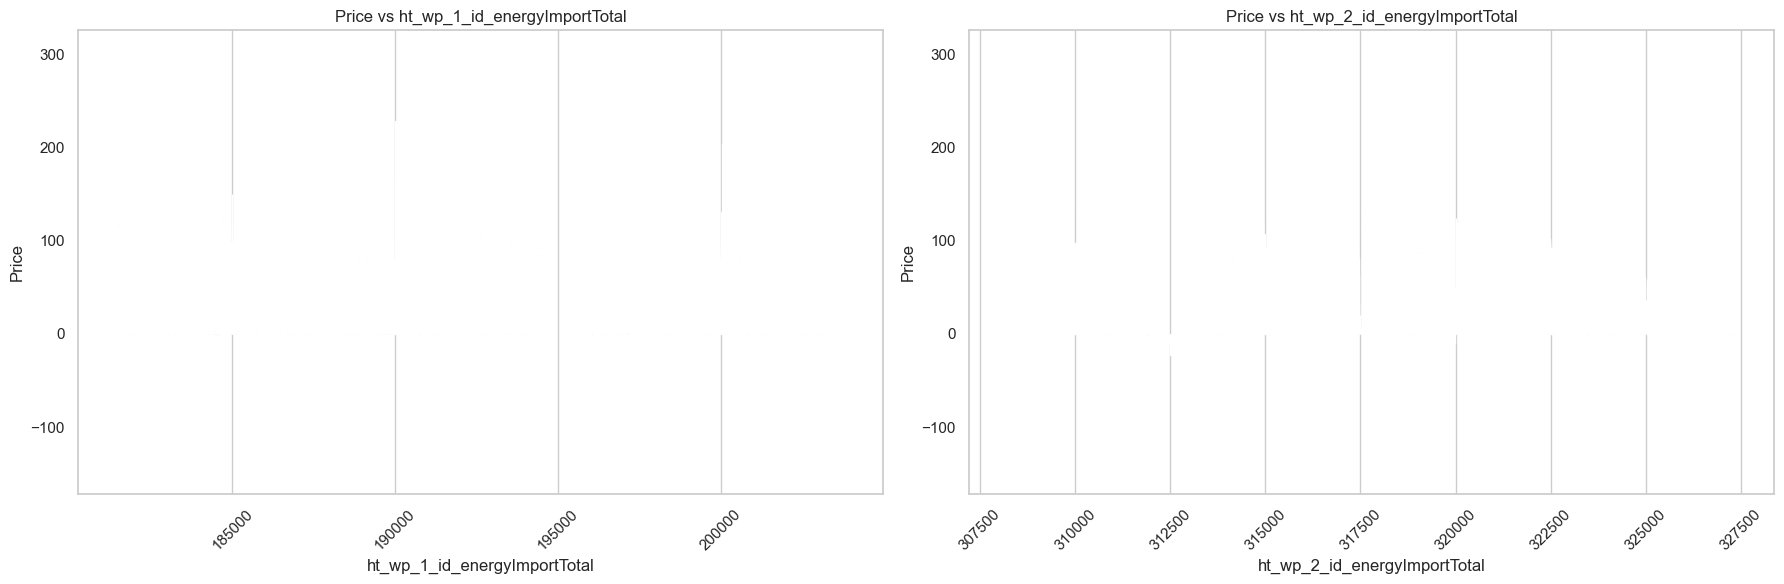

In [37]:
plt.figure(figsize=(18, 6))


for i in range(1, 3):
    col = df_res.columns[i] 
    x = df_res[col]
    y = df_res['energie_prijs_currentPrice']  
    print(x,y)
    plt.subplot(1, 2, i) 
    plt.bar(x, y, width=5, color='blue' if i == 1 else 'green') 
    plt.title(f"Price vs {col}")  
    plt.xlabel(col)  
    plt.ylabel("Price") 
    plt.xticks(rotation=45) 
    plt.grid(axis='y')  
    
plt.tight_layout()  
plt.show()

In [38]:
#Ofc it has to be 3d plot, 3rd variable is needed to observe some changes

### 3D Plot

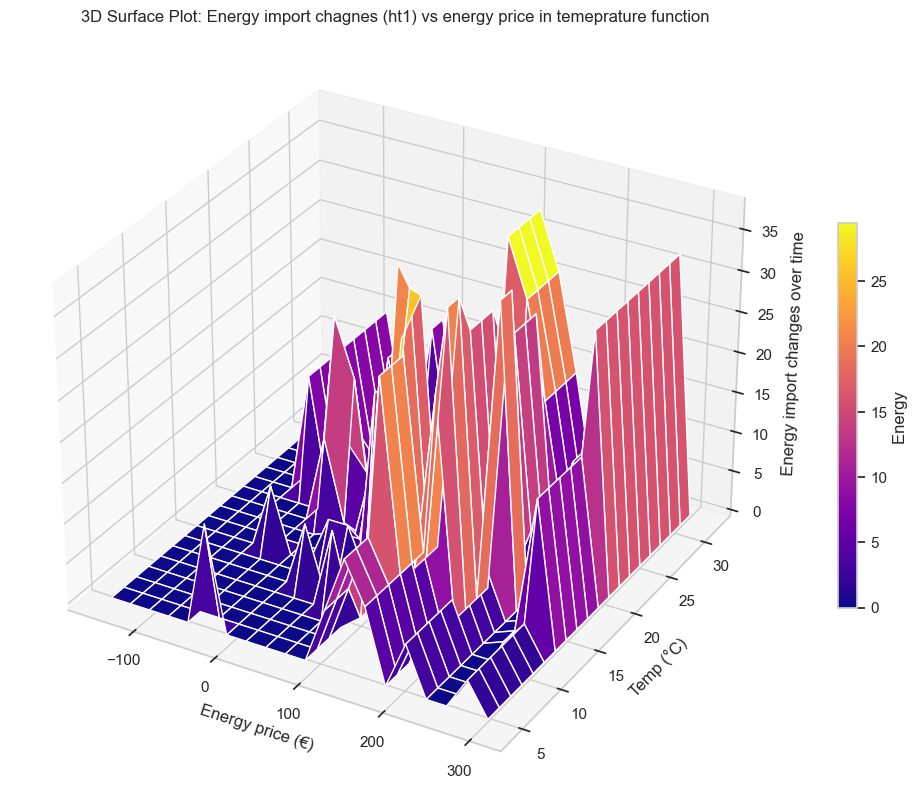

In [39]:
from scipy.interpolate import griddata

# Prepare data

temperature=df_res['weather_temperature']
prices = df_res['energie_prijs_currentPrice']
energy_import = df_res["ht_wp_1_id_energyImportTotal_delta"]

price_grid = np.linspace(min(prices),max(prices), 20)
temp_grid = np.linspace(min(temperature), max(temperature), 20)  

price_grid, temp_grid=np.meshgrid(price_grid, temp_grid)
energy_import_grid=griddata((temperature, prices), energy_import, (temp_grid, price_grid), method='nearest')

fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(price_grid, temp_grid, energy_import_grid, cmap='plasma')

ax.set_xlabel('Energy price (€)')
ax.set_ylabel('Temp (°C)')
ax.set_zlabel('Energy import changes over time')

cbar = fig.colorbar(surf, shrink=0.5)
cbar.set_label('Energy ')

plt.title('3D Surface Plot: Energy import chagnes (ht1) vs energy price in temeprature function')
plt.show()


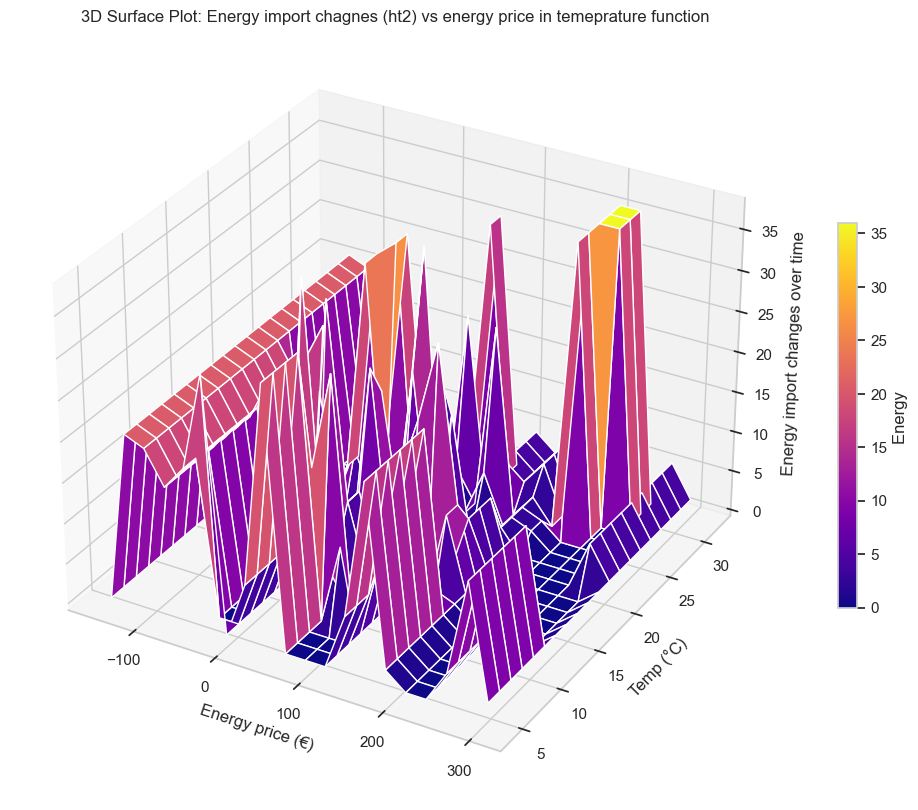

In [40]:
from scipy.interpolate import griddata

# Prepare data

temperature=df_res['weather_temperature']
prices = df_res['energie_prijs_currentPrice']
energy_import = df_res["ht_wp_2_id_energyImportTotal_delta"]

price_grid = np.linspace(min(prices),max(prices), 20)
temp_grid = np.linspace(min(temperature), max(temperature), 20)  

price_grid, temp_grid=np.meshgrid(price_grid, temp_grid)
energy_import_grid=griddata((temperature, prices), energy_import, (temp_grid, price_grid), method='nearest')

fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(price_grid, temp_grid, energy_import_grid, cmap='plasma')

ax.set_xlabel('Energy price (€)')
ax.set_ylabel('Temp (°C)')
ax.set_zlabel('Energy import changes over time')

cbar = fig.colorbar(surf, shrink=0.5)
cbar.set_label('Energy ')

plt.title('3D Surface Plot: Energy import chagnes (ht2) vs energy price in temeprature function')
plt.show()

## Frequency
### - Determine average values for larger time intervals (weekly)
### - Determine the amount of energy production for an average price
### - Presented on 2d and 3d graphs


In [41]:
df_res.head(30)

,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal,ht_wp_2_id_energyImportTotal,weather_temperature,energie_prijs_currentPrice_delta,ht_wp_1_id_energyImportTotal_delta,ht_wp_2_id_energyImportTotal_delta,weather_temperature_delta
timestamp,,,,,,,,
2024-06-17 17:00:00,77.54,181401.0,308177.0,20.933333,23.47,19.0,0.0,-0.065000
2024-06-17 18:00:00,101.36,181420.0,308177.0,20.860000,23.82,19.0,0.0,-0.073333
2024-06-17 19:00:00,139.00,181439.0,308177.0,20.355000,37.64,19.0,0.0,-0.505000
2024-06-17 20:00:00,181.54,181446.0,308197.0,19.313333,42.54,7.0,20.0,-1.041667
2024-06-17 21:00:00,196.93,181446.0,308217.0,17.941667,15.39,0.0,20.0,-1.371667
2024-06-17 22:00:00,126.61,181446.0,308237.0,16.290000,-70.32,0.0,20.0,-1.651667
2024-06-17 23:00:00,103.39,181446.0,308261.0,14.955000,-23.22,0.0,24.0,-1.335000
2024-06-18 00:00:00,70.16,181446.0,308266.0,14.320000,-33.23,0.0,5.0,-0.635000
2024-06-18 01:00:00,84.90,181446.0,308266.0,13.901667,14.74,0.0,0.0,-0.418333


### Average values for every week

In [42]:
weekly_avg_prices = df_res['energie_prijs_currentPrice'].resample('W').mean()
print(weekly_avg_prices)

timestamp
2024-06-23     95.203333
2024-06-30     71.836310
2024-07-07     43.818383
2024-07-14     66.863095
2024-07-21     74.200595
2024-07-28     72.352262
2024-08-04     69.615833
2024-08-11     72.389702
2024-08-18     87.167469
2024-08-25     56.055036
2024-09-01    101.130099
2024-09-08     88.788681
2024-09-15     75.792081
2024-09-22     77.437857
2024-09-29     67.947619
2024-10-06     81.999464
2024-10-13     94.474805
Freq: W-SUN, Name: energie_prijs_currentPrice, dtype: float64


In [43]:
# More variety between those

In [44]:

df_res_copy = df_res[['energie_prijs_currentPrice', 'ht_wp_1_id_energyImportTotal_delta', 'ht_wp_2_id_energyImportTotal_delta']].copy()

weekly_avg_df = df_res_copy.resample('W').agg({
    'energie_prijs_currentPrice': 'mean', 
    'ht_wp_1_id_energyImportTotal_delta': 'sum',  
    'ht_wp_2_id_energyImportTotal_delta': 'sum'   
})

print(weekly_avg_df)

            energie_prijs_currentPrice  ht_wp_1_id_energyImportTotal_delta  \
timestamp                                                                    
2024-06-23                   95.203333                               680.0   
2024-06-30                   71.836310                              1581.0   
2024-07-07                   43.818383                              1048.0   
2024-07-14                   66.863095                              1596.0   
2024-07-21                   74.200595                              1061.0   
2024-07-28                   72.352262                              1472.0   
2024-08-04                   69.615833                               937.0   
2024-08-11                   72.389702                              1352.0   
2024-08-18                   87.167469                              1736.0   
2024-08-25                   56.055036                               789.0   
2024-09-01                  101.130099                          

In [45]:
print(weekly_avg_df.index)

DatetimeIndex(['2024-06-23', '2024-06-30', '2024-07-07', '2024-07-14',
               '2024-07-21', '2024-07-28', '2024-08-04', '2024-08-11',
               '2024-08-18', '2024-08-25', '2024-09-01', '2024-09-08',
               '2024-09-15', '2024-09-22', '2024-09-29', '2024-10-06',
               '2024-10-13'],
              dtype='datetime64[ns]', name='timestamp', freq='W-SUN')


In [46]:
print(weekly_avg_df["energie_prijs_currentPrice"])

timestamp
2024-06-23     95.203333
2024-06-30     71.836310
2024-07-07     43.818383
2024-07-14     66.863095
2024-07-21     74.200595
2024-07-28     72.352262
2024-08-04     69.615833
2024-08-11     72.389702
2024-08-18     87.167469
2024-08-25     56.055036
2024-09-01    101.130099
2024-09-08     88.788681
2024-09-15     75.792081
2024-09-22     77.437857
2024-09-29     67.947619
2024-10-06     81.999464
2024-10-13     94.474805
Freq: W-SUN, Name: energie_prijs_currentPrice, dtype: float64


In [47]:
weekly_avg_df.describe()

,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal_delta,ht_wp_2_id_energyImportTotal_delta
count,17.000000,17.000000,17.000000
mean,76.298390,1321.941176,1131.294118
std,14.439346,425.125198,461.830023
min,43.818383,680.000000,189.000000
25%,69.615833,1022.000000,990.000000
50%,74.200595,1352.000000,1115.000000
75%,87.167469,1596.000000,1509.000000
max,101.130099,2305.000000,1765.000000


In [48]:
weekly_avg_df=weekly_avg_df.dropna()
weekly_avg_df.head(17)

,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal_delta,ht_wp_2_id_energyImportTotal_delta
timestamp,,,
2024-06-23,95.203333,680.0,1191.0
2024-06-30,71.836310,1581.0,1614.0
2024-07-07,43.818383,1048.0,1679.0
2024-07-14,66.863095,1596.0,1091.0
2024-07-21,74.200595,1061.0,1525.0
2024-07-28,72.352262,1472.0,990.0
2024-08-04,69.615833,937.0,1374.0
2024-08-11,72.389702,1352.0,982.0
2024-08-18,87.167469,1736.0,438.0


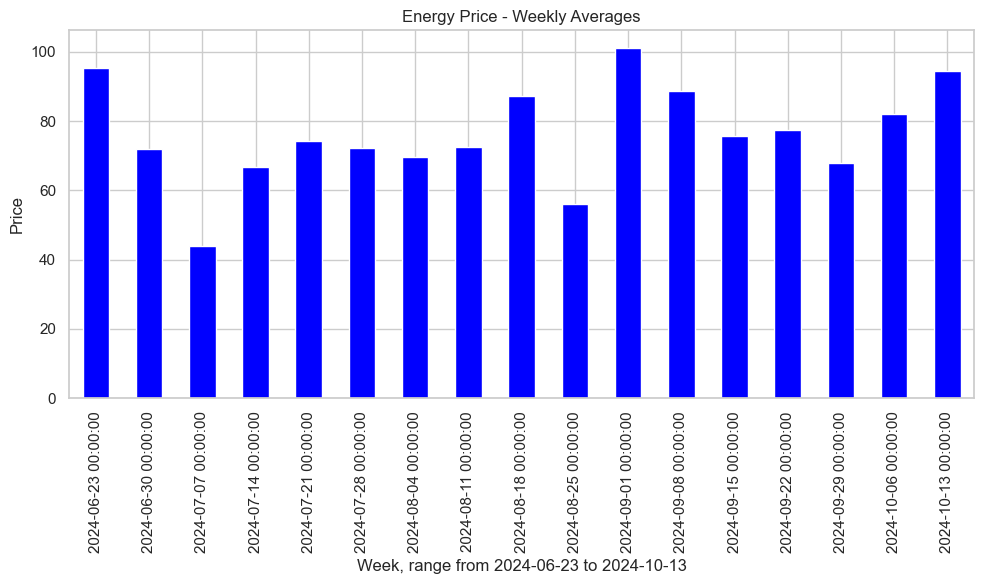

In [49]:
y = weekly_avg_df["energie_prijs_currentPrice"]
y.plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Energy Price - Weekly Averages')
plt.xlabel('Week, range from 2024-06-23 to 2024-10-13')
plt.ylabel('Price')
plt.xticks(rotation=90) 
plt.grid(True)

plt.tight_layout()
plt.show()

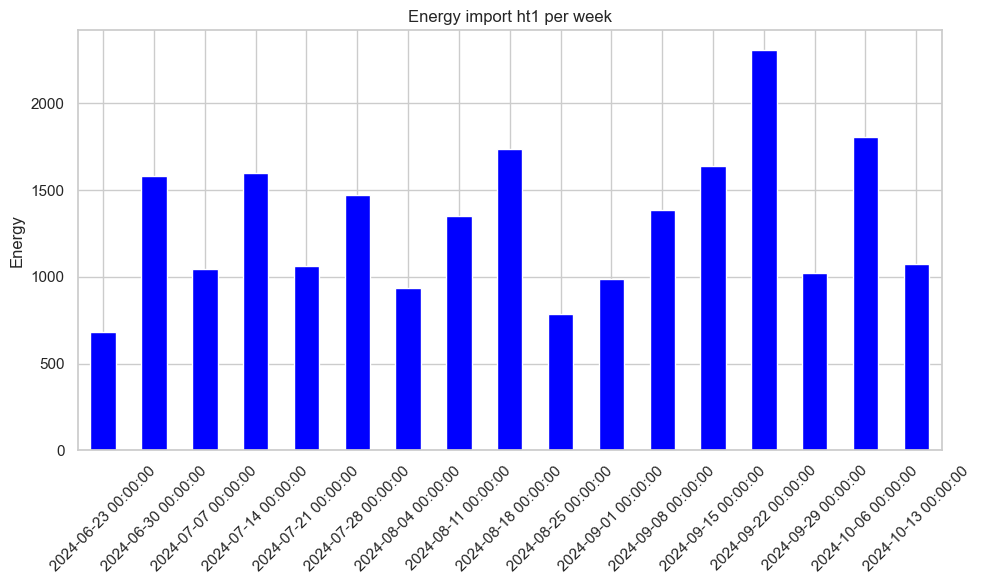

In [50]:
y = weekly_avg_df["ht_wp_1_id_energyImportTotal_delta"]
y.plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Energy import ht1 per week')
plt.xlabel('')
plt.ylabel('Energy')
plt.xticks(rotation=45) 
plt.grid(True)

plt.tight_layout()
plt.show()

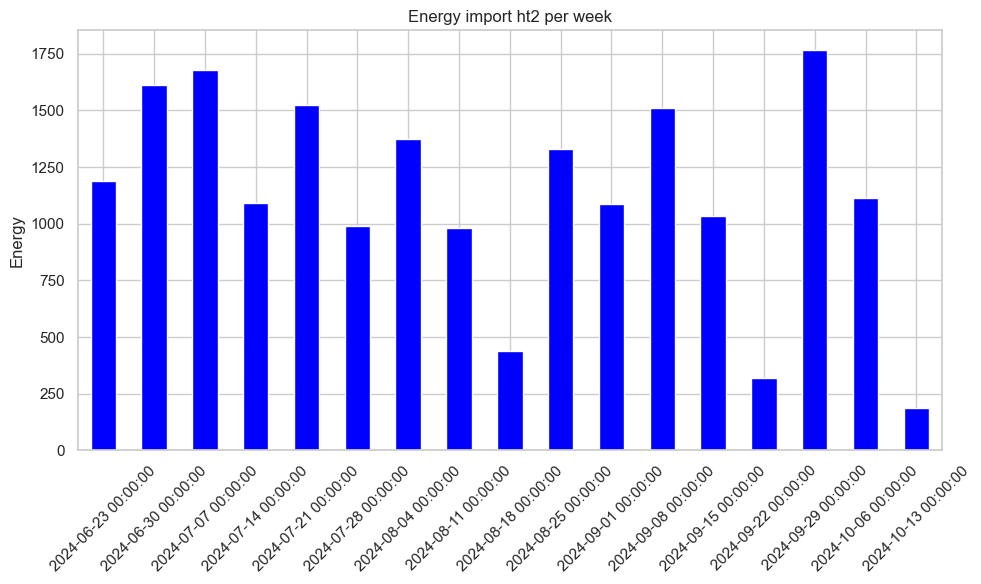

In [51]:
y = weekly_avg_df["ht_wp_2_id_energyImportTotal_delta"]
y.plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Energy import ht2 per week')
plt.xlabel('')
plt.ylabel('Energy')
plt.xticks(rotation=45) 
plt.grid(True)

plt.tight_layout()
plt.show()

In [52]:
#CONVERT TIME INDEX TO 1-17

weekly_avg_df.index = range(len(weekly_avg_df))

### Weekly energy price vs weekly energy import

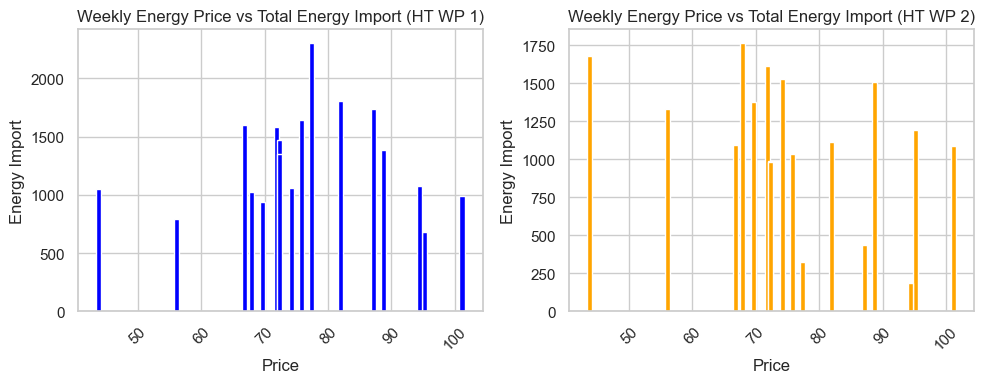

In [53]:

plt.figure(figsize=(10, 4))

#y1_min = weekly_avg_df["ht_wp_1_id_energyImportTotal"].quantile(0.01)
#y2_min = weekly_avg_df["ht_wp_2_id_energyImportTotal"].quantile(0.01)

plt.subplot(1, 2, 1) 
x1 = weekly_avg_df["energie_prijs_currentPrice"]
y1 = weekly_avg_df["ht_wp_1_id_energyImportTotal_delta"]
plt.bar(x1, y1, color='blue')
plt.title('Weekly Energy Price vs Total Energy Import (HT WP 1)')
plt.xlabel('Price')
plt.ylabel('Energy Import')
plt.xticks(rotation=45)
#plt.ylim(y1_min, None)
plt.grid(True)


plt.subplot(1, 2, 2)  
x2 = weekly_avg_df["energie_prijs_currentPrice"]
y2 = weekly_avg_df["ht_wp_2_id_energyImportTotal_delta"]
plt.bar(x2, y2, color='orange')
plt.title('Weekly Energy Price vs Total Energy Import (HT WP 2)')
plt.xlabel('Price')
plt.ylabel('Energy Import')
plt.xticks(rotation=45)
#plt.ylim(y2_min, None)
plt.grid(True)

plt.tight_layout()
plt.show()

In [54]:
weekly_avg_df.head(17)

,energie_prijs_currentPrice,ht_wp_1_id_energyImportTotal_delta,ht_wp_2_id_energyImportTotal_delta
0,95.203333,680.0,1191.0
1,71.836310,1581.0,1614.0
2,43.818383,1048.0,1679.0
3,66.863095,1596.0,1091.0
4,74.200595,1061.0,1525.0
5,72.352262,1472.0,990.0
6,69.615833,937.0,1374.0
7,72.389702,1352.0,982.0
8,87.167469,1736.0,438.0
9,56.055036,789.0,1328.0


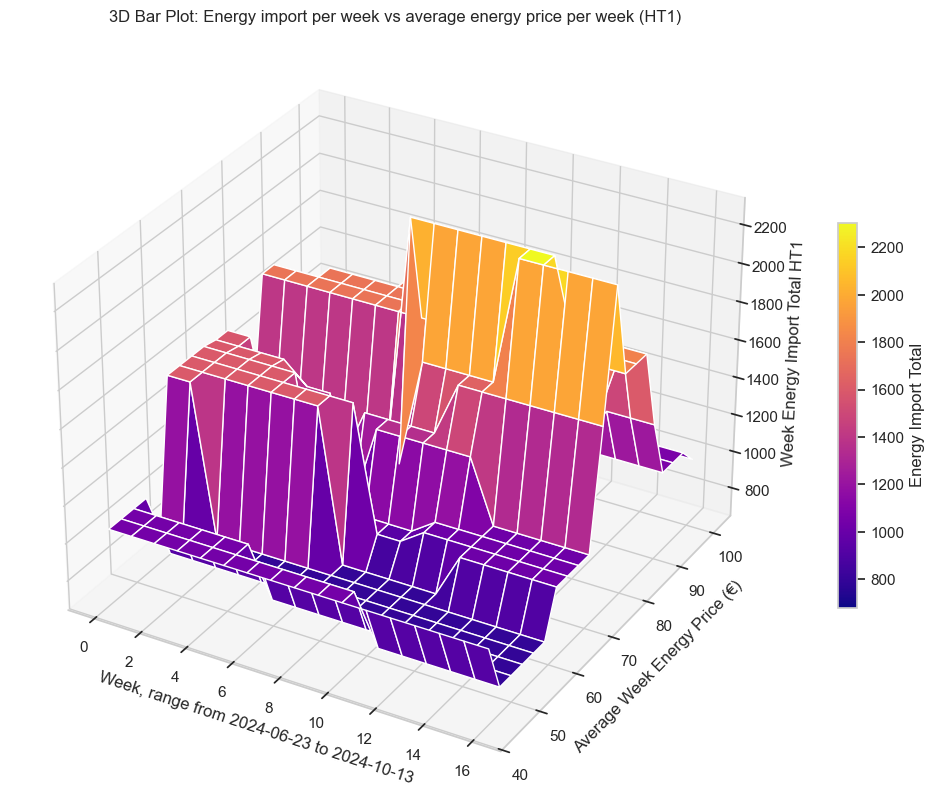

In [55]:
from scipy.interpolate import griddata

prices = weekly_avg_df['energie_prijs_currentPrice']
energy_import = weekly_avg_df['ht_wp_1_id_energyImportTotal_delta']
dates = weekly_avg_df.index  

price_grid = np.linspace(min(prices), max(prices), 20)
date_grid = np.linspace(0, len(dates) - 1, len(dates)) 

price_grid, date_grid = np.meshgrid(price_grid, date_grid)

energy_import_grid = griddata((dates, prices), energy_import, (date_grid, price_grid), method='nearest')

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(date_grid, price_grid, energy_import_grid, cmap='plasma')

ax.set_xlabel('Week, range from 2024-06-23 to 2024-10-13')
ax.set_ylabel('Average Week Energy Price (€)')
ax.set_zlabel('Week Energy Import Total HT1')


cbar = fig.colorbar(surf, shrink=0.5)
cbar.set_label('Energy Import Total')


plt.title('3D Bar Plot: Energy import per week vs average energy price per week (HT1)')
plt.show()





### Without interpolation

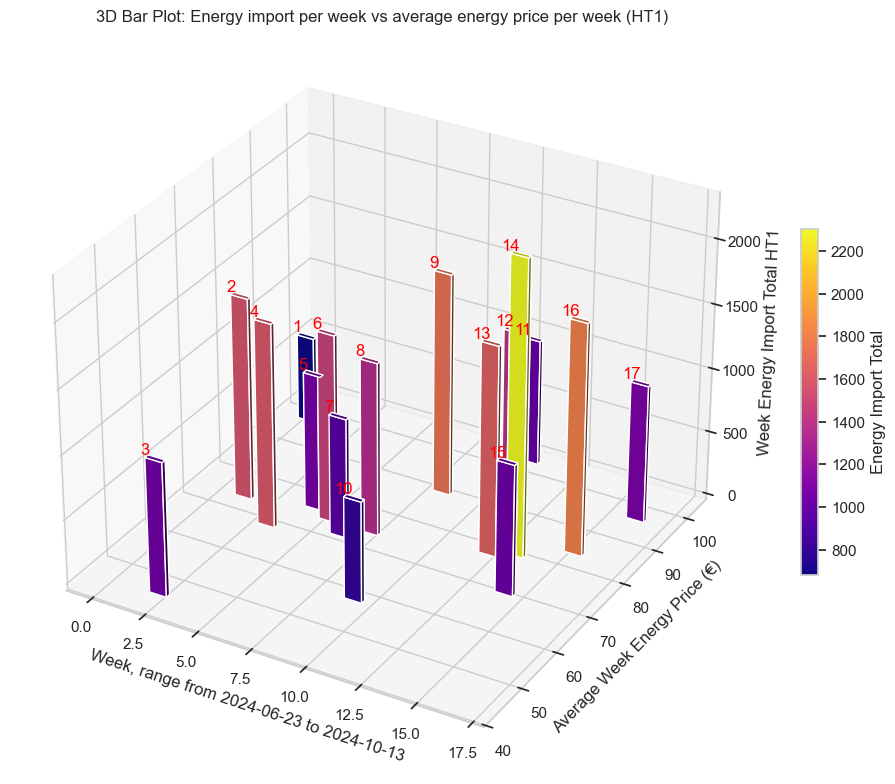

In [56]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

prices = weekly_avg_df['energie_prijs_currentPrice'].values
energy_import = weekly_avg_df['ht_wp_1_id_energyImportTotal_delta'].values
dates = np.arange(len(weekly_avg_df))  

fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(111, projection='3d')

dx = dy = 0.8  
dz = energy_import  

norm = plt.Normalize(min(energy_import), max(energy_import))
colors = cm.plasma(norm(energy_import))

bars = ax.bar3d(dates, prices, np.zeros_like(dz), dx, dy, dz, color=colors, shade=True)

for i in range(len(energy_import)):
    week_number = dates[i]  
    ax.text(dates[i], prices[i], dz[i], f'{week_number+1}', color='red', ha='center', va='bottom')

ax.set_xlabel('Week, range from 2024-06-23 to 2024-10-13')
ax.set_ylabel('Average Week Energy Price (€)')
ax.set_zlabel('Week Energy Import Total HT1')

mappable = cm.ScalarMappable(cmap='plasma', norm=norm)
mappable.set_array(energy_import)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.3)
cbar.set_label('Energy Import Total')

plt.title('3D Bar Plot: Energy import per week vs average energy price per week (HT1)')
plt.show()


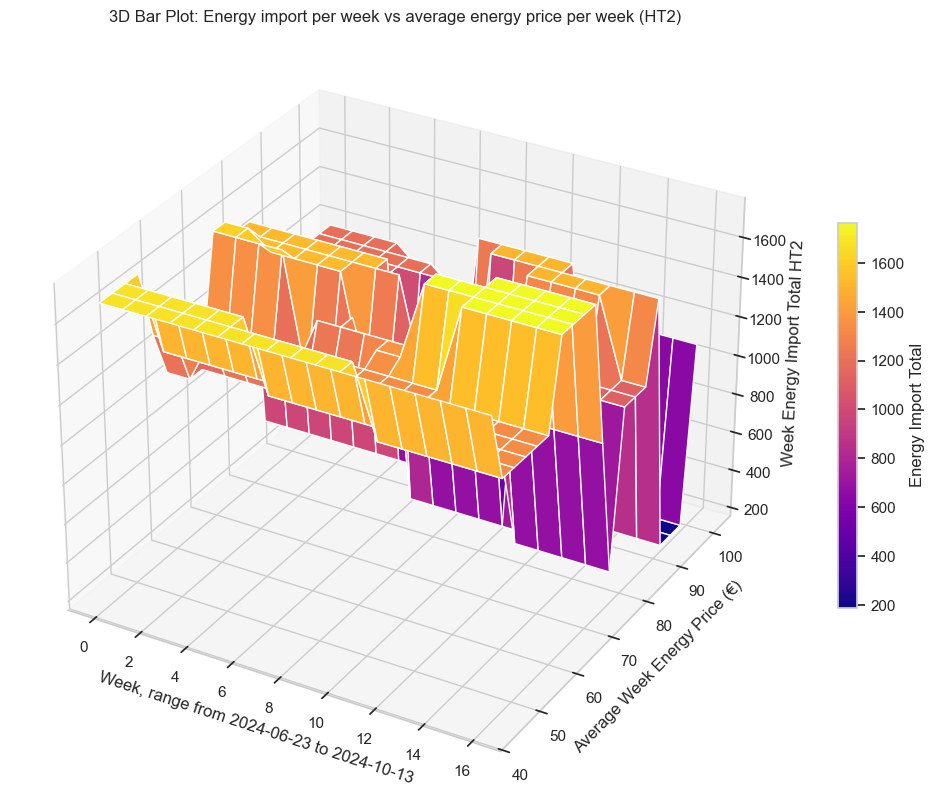

In [57]:
prices = weekly_avg_df['energie_prijs_currentPrice']
energy_import = weekly_avg_df['ht_wp_2_id_energyImportTotal_delta']
dates = weekly_avg_df.index  

price_grid = np.linspace(min(prices), max(prices), 20)
date_grid = np.linspace(0, len(dates) - 1, len(dates)) 

price_grid, date_grid = np.meshgrid(price_grid, date_grid)

energy_import_grid = griddata((dates, prices), energy_import, (date_grid, price_grid), method='nearest')

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(date_grid, price_grid, energy_import_grid, cmap='plasma')

ax.set_xlabel('Week, range from 2024-06-23 to 2024-10-13')
ax.set_ylabel('Average Week Energy Price (€)')
ax.set_zlabel('Week Energy Import Total HT2')


cbar = fig.colorbar(surf, shrink=0.5)
cbar.set_label('Energy Import Total')


plt.title('3D Bar Plot: Energy import per week vs average energy price per week (HT2)')
plt.show()

### Without interpolation

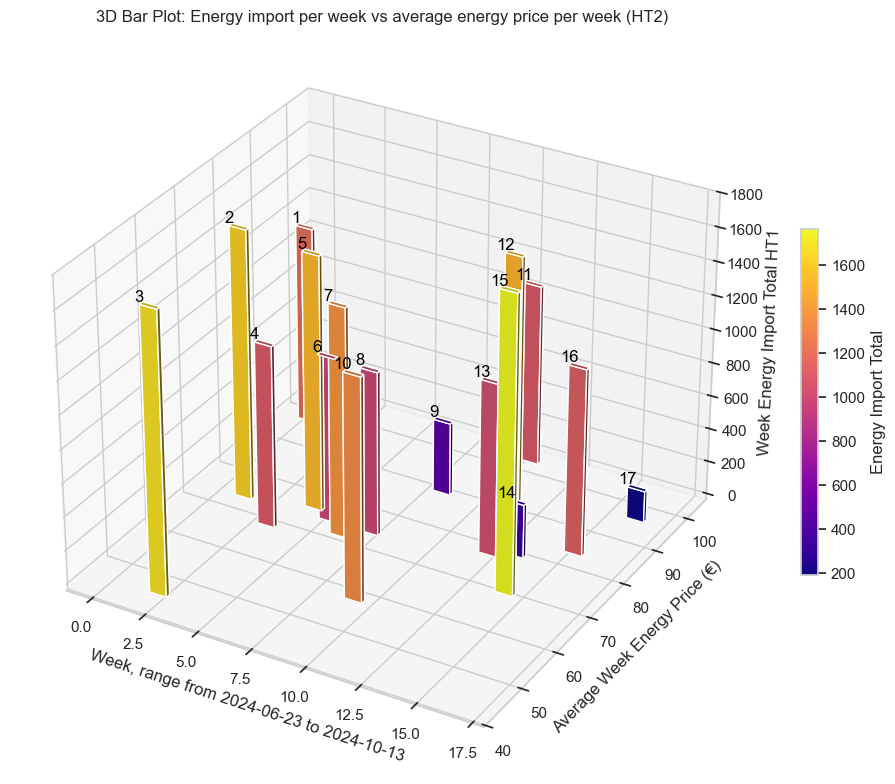

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

prices = weekly_avg_df['energie_prijs_currentPrice'].values
energy_import = weekly_avg_df['ht_wp_2_id_energyImportTotal_delta'].values
dates = np.arange(len(weekly_avg_df))  

fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(111, projection='3d')

dx = dy = 0.8  
dz = energy_import  

norm = plt.Normalize(min(energy_import), max(energy_import))
colors = cm.plasma(norm(energy_import))

bars = ax.bar3d(dates, prices, np.zeros_like(dz), dx, dy, dz, color=colors, shade=True)

for i in range(len(energy_import)):
    week_number = dates[i]  
    ax.text(dates[i], prices[i], dz[i], f'{week_number+1}', color='black', ha='center', va='bottom')

ax.set_xlabel('Week, range from 2024-06-23 to 2024-10-13')
ax.set_ylabel('Average Week Energy Price (€)')
ax.set_zlabel('Week Energy Import Total HT1')

mappable = cm.ScalarMappable(cmap='plasma', norm=norm)
mappable.set_array(energy_import)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.3)
cbar.set_label('Energy Import Total')

plt.title('3D Bar Plot: Energy import per week vs average energy price per week (HT2)')
plt.show()